# Image Classification Model Deployment

1. [Introduction](#Introduction)
4. [Deploy the Model for Realtime Inference](#Deploy-the-Model-for-Realtime-Inference)
    1. [Create endpoint configuration](#Create-endpoint-configuration) 
    2. [Create endpoint](#Create-endpoint) 
    3. [Perform inference](#Perform-inference) 
    4. [Clean up](#Clean-up)


## 1. Introduction

In this notebook, we will use deploy our image classification model for making real-time predictions.

First, we need to set up the linkage and authentication to AWS services. There are three parts to this:

* The roles used to give learning and hosting access to your data. This will automatically be obtained from the role used to start the notebook
* The S3 bucket that you want to use for training and model data
* The Amazon sagemaker image classification docker image which need not be changed

In [1]:
%%time
import time
from time import gmtime, strftime
import io
import numpy as np
import pickle
import s3fs
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.image_uris import retrieve

role = get_execution_role()

bucket = sagemaker.Session().default_bucket()

training_image = retrieve("image-classification", boto3.Session().region_name)

s3 = s3fs.S3FileSystem()
s3_client = boto3.client("s3")

CPU times: user 1.38 s, sys: 185 ms, total: 1.56 s
Wall time: 10.5 s


## 2. Deploy Model for Realtime Inference

We now host the model with an endpoint and perform realtime inference.

This section involves several steps,
1. [Create endpoint configuration](#CreateEndpointConfiguration) - Create a configuration defining an endpoint.
1. [Create endpoint](#CreateEndpoint) - Use the configuration to create an inference endpoint.
1. [Perform inference](#PerformInference) - Perform inference on some input data using the endpoint.
1. [Clean up](#CleanUp) - Delete the endpoint and model

#### a) Create Endpoint Configuration
At launch, we will support configuring REST endpoints in hosting with multiple models, e.g. for A/B testing purposes. In order to support this, customers create an endpoint configuration, that describes the distribution of traffic across the models, whether split, shadowed, or sampled in some way.

In addition, the endpoint configuration describes the instance type required for model deployment, and at launch will describe the autoscaling configuration.

In [4]:
# Model name
job_name_prefix = "PCAM-image-classification"
job_name = job_name_prefix + "-" + time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
model_name = 'PCAM-image-classification-model-2021-10-04-17-55-20'

# sagemaker
sage = boto3.Session().client(service_name="sagemaker")
sagemaker = boto3.client("sagemaker")

In [6]:
# Endpoint configuration
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_config_name = job_name_prefix + "-epc-" + timestamp
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": model_name,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint configuration name: {}".format(endpoint_config_name))
print("Endpoint configuration arn:  {}".format(endpoint_config_response["EndpointConfigArn"]))

Endpoint configuration name: PCAM-image-classification-epc--2021-10-09-14-56-46
Endpoint configuration arn:  arn:aws:sagemaker:us-east-1:513033806411:endpoint-config/pcam-image-classification-epc--2021-10-09-14-56-46


#### b) Create Endpoint
Next, we create the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be validated and incorporated into production applications. This takes 9-11 minutes to complete.

In [8]:
# Create endpoint
timestamp = time.strftime("-%Y-%m-%d-%H-%M-%S", time.gmtime())
endpoint_name = job_name_prefix + "-ep-" + timestamp
print("Endpoint name: {}".format(endpoint_name))

endpoint_params = {
    "EndpointName": endpoint_name,
    "EndpointConfigName": endpoint_config_name,
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print("EndpointArn = {}".format(endpoint_response["EndpointArn"]))

Endpoint name: PCAM-image-classification-ep--2021-10-09-14-59-55
EndpointArn = arn:aws:sagemaker:us-east-1:513033806411:endpoint/pcam-image-classification-ep--2021-10-09-14-59-55


Now the endpoint can be created. It may take sometime to create the endpoint...

In [9]:
# get the status of the endpoint
response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response["EndpointStatus"]
print("EndpointStatus = {}".format(status))


# wait until the status has changed
sagemaker.get_waiter("endpoint_in_service").wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response["EndpointStatus"]
print("Endpoint creation ended with EndpointStatus = {}".format(status))

if status != "InService":
    raise Exception("Endpoint creation failed.")

EndpointStatus = Creating
Endpoint creation ended with EndpointStatus = InService


If you see the message,

> `Endpoint creation ended with EndpointStatus = InService`

then congratulations! You now have a functioning inference endpoint. You can confirm the endpoint configuration and status by navigating to the "Endpoints" tab in the AWS SageMaker console.

We will finally create a runtime object from which we can invoke the endpoint.

#### c) Perform Inference
Finally, the customer can now validate the model for use. They can obtain the endpoint from the client library using the result from previous operations, and generate classifications from the trained model using that endpoint.


In [15]:
runtime = boto3.Session().client(service_name="runtime.sagemaker")

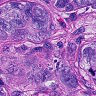

In [14]:
# Download test image
s3_client = boto3.client("s3")

file_name = "test3.jpg"
object_name = "lymph-node-image-classification/images/color/test/test_3.jpg"
s3_client.download_file(bucket, object_name, file_name)

# test image
from IPython.display import Image

Image(file_name)

Evaluate the image through the network for inference. The network outputs class probabilities and we will select the class with the maximum probability as the final class output. This image is predicted as **positive** for metastatic cancer with a probability of **0.9999**.

In [16]:
import json
import numpy as np

with open(file_name, "rb") as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(
    EndpointName=endpoint_name, ContentType="application/x-image", Body=payload
)
result = response["Body"].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)
object_categories = ['Negative','Positive']
print("Result: label - " + object_categories[index] + ", probability - " + str(result[index]))

Result: label - Positive, probability - 0.9999039173126221


#### d) Clean up

That's it! We've successfully deployed our model for realtime inference! Now that we are finished with the endpoint, we can just delete it and the backing instances will be released.

In [19]:
sage.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': 'bfcb7577-fcef-407e-9602-003b7f646f33',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'bfcb7577-fcef-407e-9602-003b7f646f33',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Sat, 09 Oct 2021 15:29:13 GMT'},
  'RetryAttempts': 0}}